### Import data

In [119]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.metrics import mean_squared_error

In [2]:
# Import data
feature_train = pd.read_csv("/Users/chensong/Downloads/yelp_feature_train.csv", encoding='utf-8')
feature_val = pd.read_csv("/Users/chensong/Downloads/yelp_feature_val.csv", encoding='utf-8')
feature_test = pd.read_csv("/Users/chensong/Downloads/yelp_feature_test.csv", encoding='utf-8')

In [31]:
feature_train.head(1)

,business_id,user_id,review_stars,review_like,text,text_len,restaurant_avg_stars,restaurant_review_count,city_review_count,centrality,user_avg_stars,user_review_count,user_fans,user_period,user_compliments,user_votes,popularity,pop_label
0,oj8qk3W7O9oq15VIs-vYJQ,UreiTV1I9i-XF6_bJhK6Iw,5.0,0,new favorite place breakfast first time came h...,54,4.375,64,436.0,2.207263e-21,3.55,104,0,8,2,80,4.694428,5.0


### Data cleaning

#### Extra  features  to scale

In [32]:
# Select features
sf_train = feature_train.loc[:,~feature_train.columns.isin(['business_id', 'user_id', 'text', 'popularity', 'pop_label'])]
sf_val = feature_val.loc[:,~feature_val.columns.isin(['business_id', 'user_id', 'text', 'popularity', 'pop_label'])]
sf_test = feature_test.loc[:,~feature_test.columns.isin(['business_id', 'user_id', 'text', 'popularity', 'pop_label'])]

In [33]:
sf_train.head(2)

,business_id,review_stars,review_like,text_len,restaurant_avg_stars,restaurant_review_count,city_review_count,centrality,user_avg_stars,user_review_count,user_fans,user_period,user_compliments,user_votes
0,oj8qk3W7O9oq15VIs-vYJQ,5.0,0,54,4.375000,64,436.0,2.207263e-21,3.55,104,0,8,2,80
1,YFqlMM1tFn0C4b9aHdzOgg,4.0,0,54,4.448276,29,839.0,2.207263e-21,3.55,104,0,8,2,80


#### Scale features

In [4]:
scaler = StandardScaler()
# Fit scales
train_scale = scaler.fit_transform(sf_train)
val_scale = scaler.transform(sf_val)
test_scale = scaler.transform(sf_test)

### Tokenize review text

In [5]:
# Set parameters
MAX_NB_WORDS = 100
MAX_SEQ_LEN = 100
# Tokenize the texts
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(feature_train['text'])

In [6]:
# Transform tokens into sequences of train data
sequences = tokenizer.texts_to_sequences(feature_train['text'])
train_text_seq = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)

In [7]:
# deal with val and text data
sequences = tokenizer.texts_to_sequences(feature_val['text'])
val_text_seq = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)
sequences = tokenizer.texts_to_sequences(feature_test['text'])
test_text_seq = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)

In [8]:
vocab = {k: v-1 for k, v in tokenizer.word_index.items() if tokenizer.word_counts[k] >= 3000}

### TF-IDF

In [9]:
tfidf = TfidfVectorizer(ngram_range=(1,2), vocabulary=vocab)
tfidf.fit(feature_train['text'] )
tfidf_train = tfidf.transform(feature_train['text'] )


In [10]:
tfidf_train_array = tfidf_train.toarray()

In [11]:
#val
tfidf_val = tfidf.transform(feature_val['text'] )
tfidf_val_array = tfidf_val.toarray()

In [12]:
#test
tfidf_test = tfidf.transform(feature_test['text'] )
tfidf_test_array = tfidf_test.toarray()

### Build models

In [13]:
# Prepare data
# Train set
X_train = np.concatenate((train_text_seq, train_scale,tfidf_train_array),axis = 1)
y_train = feature_train['pop_label']

# Val set
X_val = np.concatenate((val_text_seq, val_scale,tfidf_val_array),axis = 1)
y_val = feature_val['pop_label']

# Test set
X_test = np.concatenate((test_text_seq, test_scale,tfidf_test_array),axis = 1)
y_test = feature_test['pop_label']

#### Naive Bayes

In [14]:
# Create a scaler object
sc = StandardScaler()
# Fit the scaler to the training data and transform
sc.fit(X_train)
X_train_std = sc.transform(X_train)
# Apply the scaler to the val and test data
X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)


In [60]:
model_gnb = GaussianNB()
model_gnb.fit(X_train,y_train.astype(int))

GaussianNB(priors=None, var_smoothing=1e-09)

In [61]:
y_pred_test = model_gnb.predict(X_test)

In [83]:
feature_test['pred'] = y_pred_test

In [88]:
df_test = feature_test.groupby('business_id')[['pop_label', 'pred']].mean()

In [89]:
df_test['pred_label'] = np.round(df_test['pred'])

In [90]:
df_test.head()

,pop_label,pred,pred_label
business_id,,,
--DaPTJW3-tB1vP-PfdTEg,4.0,3.375000,3.0
--GM_ORV2cYS-h38DSaCLw,2.0,2.000000,2.0
--S62v0QgkqQaVUhFnNHrw,1.0,1.210526,1.0
-1m9o3vGRA8IBPNvNqKLmA,5.0,4.554167,5.0
-1u4Q4U6OZ-CvqoxUh7gKg,4.0,4.222222,4.0


### Accuracy

In [92]:
print("Accuracy:",metrics.accuracy_score(df_test['pop_label'], df_test['pred_label']))

Accuracy: 0.31996251171508905


In [93]:
def unique(list): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    for x in unique_list: 
        return unique_list

In [105]:
# get classification labels
unique_label = np.sort(unique(df_test['pop_label']))

[Text(0, 0.5, '1.0'),
 Text(0, 1.5, '2.0'),
 Text(0, 2.5, '3.0'),
 Text(0, 3.5, '4.0'),
 Text(0, 4.5, '5.0')]

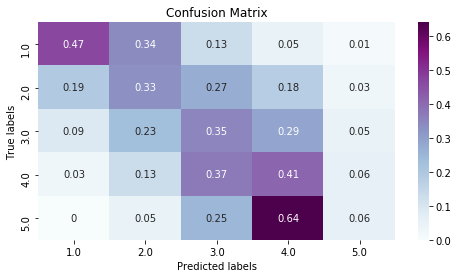

In [124]:
cm = np.round(confusion_matrix(
    df_test['pop_label'], df_test['pred_label'],
    unique_label, normalize='true'
), 2)
fig, ax = plt.subplots(figsize=(8, 4))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g',cmap='BuPu'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(unique_label)
ax.yaxis.set_ticklabels(unique_label)


In [120]:
realDummy = pd.get_dummies(df_test['pop_label'])

## calculate RMSE
true_labs = realDummy.to_numpy().argmax(axis=1)+1
pred_labs = df_test['pred_label']
rmse = (mean_squared_error(true_labs, pred_labs))**(0.5)
print("RMSE:\t", round(rmse, 4))

RMSE:	 1.2092


In [160]:
def prediction(X_test, model):
    # predict
    predict = pd.DataFrame(model.predict_proba(X_test), columns=model.classes_)
    #predict = pd.DataFrame(model.predict(X_test))
    predict = predict.add_prefix('pred_')
    
    predict['meanPred'] = 0
    for i in range(1,6):
        predict['meanPred'] = predict['meanPred'] + predict['pred_'+str(i)] * i
    #predict['mean'] = predict['sumPred']/(np.sum(predict.iloc[:,0:5], axis=1))
    # sum(pred1~5) = 1

    predict['varPred'] = 0
    for i in range(1,6):
        predict['varPred'] = predict['varPred'] + (predict['pred_'+str(i)] * (i - predict['meanPred'])**2)
    predict['varPred'] += 1e-6

    predict['repvar'] = 1/predict['varPred']
    predict['w_mean'] = predict['meanPred']/predict['varPred']
    
    #predict.describe()
    
    return(predict)

In [161]:
test_df = prediction(X_test, model_gnb)

In [162]:
test_df.head()

,pred_1,pred_2,pred_3,pred_4,pred_5,meanPred,varPred,repvar,w_mean
0,9.336781e-01,1.116243e-35,9.074516e-06,5.624613e-23,6.631284e-02,1.265269,0.990675,1.009413,1.277179e+00
1,1.000000e+00,1.519500e-18,7.833816e-17,2.034631e-27,6.315512e-17,1.000000,0.000001,999999.998675,1.000000e+06
2,1.953967e-29,2.100869e-40,9.841617e-24,2.569243e-27,1.000000e+00,5.000000,0.000001,1000000.000000,5.000000e+06
3,7.469506e-125,7.342967e-52,1.620119e-06,9.995660e-01,4.324067e-04,4.000431,0.000435,2299.689864,9.199750e+03
4,1.000000e+00,2.476337e-74,1.030130e-98,4.993414e-154,7.748091e-238,1.000000,0.000001,1000000.000000,1.000000e+06


In [166]:
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def evaluate_model(predict_df):
    ## set up
    tempDF = pd.DataFrame({"business_id": feature_test['business_id'], 
                           "real_label": y_test})
    tempDF = pd.concat([tempDF, predict_df], axis=1)

    resultDF = tempDF.groupby(['business_id', 'real_label']).sum()
    resultDF['grand_mean'] = round(resultDF['w_mean']/resultDF['repvar'], 0)
    resultDF['grand_var'] = 1/resultDF['repvar']
    resultDF.reset_index(inplace=True)
    # resultDF['grand_mean'].describe()
    
    ## accuracy
    accuracy = round(accuracy_score(resultDF["real_label"], resultDF['grand_mean']), 3)
    print("accuracy score:", accuracy)
    print("classification report:\n", classification_report(resultDF["real_label"], resultDF['grand_mean']))
    
    realDummy = pd.get_dummies(resultDF['real_label'], prefix='real')

    ## calculate RMSE
    true_labs = realDummy.to_numpy().argmax(axis=1)+1
    pred_labs = np.round(resultDF['grand_mean'])
    rmse = (mean_squared_error(true_labs, pred_labs))**(0.5)
    print("RMSE:\t", round(rmse, 4))
    
    ## plot confusion matrix
    labels = [1,2,3,4,5]
    #labels = [0,1,2,3,4]
    cm = confusion_matrix(true_labs, pred_labs, labels, normalize='true')
    cm_df = pd.DataFrame(cm, index=[i for i in labels], columns=[i for i in labels])

    plt.figure(figsize = (10,7))
    ax = plt.subplot()
    sns.heatmap(cm_df, annot=True, cmap='BuPu', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    
    return(resultDF, rmse)

accuracy score: 0.328
classification report:
               precision    recall  f1-score   support

         1.0       0.53      0.59      0.56      1050
         2.0       0.28      0.27      0.27      1015
         3.0       0.25      0.30      0.27      1034
         4.0       0.27      0.35      0.31      1130
         5.0       0.32      0.13      0.18      1106

    accuracy                           0.33      5335
   macro avg       0.33      0.33      0.32      5335
weighted avg       0.33      0.33      0.32      5335

RMSE:	 1.2833


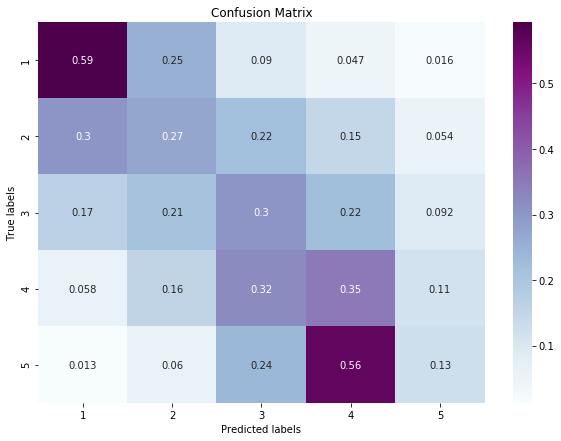

In [168]:
resultDF, rmse = evaluate_model(test_df)